c:\Users\khizra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0137 - val_loss: 0.0199
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.2328e-04 - val_loss: 0.0132
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 8.5140e-05 - val_loss: 0.0100
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6.2317e-05 - val_loss: 0.0087
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 4.6046e-05 - val_loss: 0.0086
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.6945e-05 - val_loss: 0.0063
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.2763e-05 - val_loss: 0.0057
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.5895e-05 - val_loss: 0.0054
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.3691e-05 - val_loss: 0.0040
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.8745e-05 - val_loss: 0.0036
Epoch 11/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.1886e-05 - val_loss: 0.0027
Epoch 12/30
56/56 ━━━━━

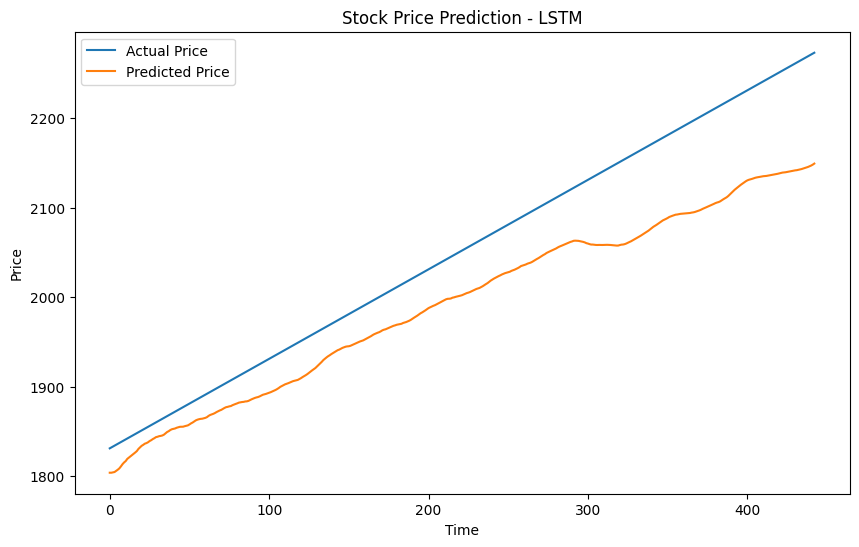

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ================================
# 1. Load Dataset
# ================================
file_path = "TeslaStock_Dataset_Cleaned.csv"
df = pd.read_csv(file_path)

# Drop Date if exists
if "Date" in df.columns:
    df = df.drop(columns=["Date"])

# Use 'Close' as target, scale all data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

# ================================
# 2. Create Sequences
# ================================
def create_sequences(data, n_steps=60):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])   # past n_steps days
        y.append(data[i, 0])         # predict 'Close' (first column)
    return np.array(X), np.array(y)

# Window size = 60 days
X, y = create_sequences(scaled_data, n_steps=60)

# Train-Test Split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================
# 3. Build LSTM Model
# ================================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ================================
# 4. Train Model
# ================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

# ================================
# 5. Evaluate Model
# ================================
y_pred = model.predict(X_test)

# Inverse scale predictions and test values
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), df.shape[1]-1))], axis=1)
)[:,0]

y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), df.shape[1]-1))], axis=1)
)[:,0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print("RNN (LSTM) Performance:")
print("MAE:", mae)
print("RMSE:", rmse)

# ================================
# 6. Plot Results
# ================================
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label="Actual Price")
plt.plot(y_pred_rescaled, label="Predicted Price")
plt.title("Stock Price Prediction - LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
